SurrogateCanny model (same as Canny, but without hysteresis thresholding and single, optimizable threshold):

torch.Size([128, 128])


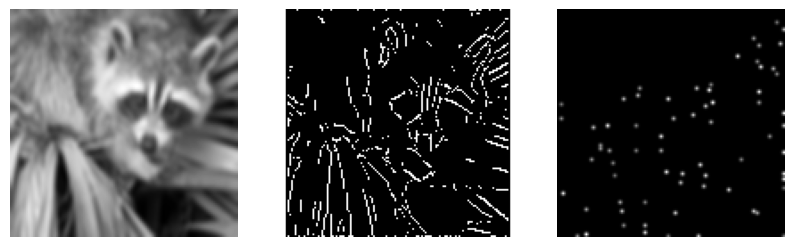

In [6]:
import torch
from torch import nn
from scipy import misc
import matplotlib.pyplot as plt
import cv2
from models import DifferentiablePhospheneSimulator,ThresholdedSobel,OrientedSobel, SurrogateCanny

# Play around!
SCREEN_SIZE = (128,128)
K_SIZE      = 3 #Size of sobel kernel (e.g. 3, 5 or 7)
THRESHOLD   = 0.2 # value of initial threshold (chose between 0 and 1)
PHOSPHENE_RESOLUTION = (30,30)
DEVICE      = 'cuda:0'
STACKSIZE   = 4
BATCHSIZE   = 5

# Dummy tensor (single 128x128 image)
img   = misc.face(gray=True)
img   = cv2.GaussianBlur(img,(35,35),10)
dummy = torch.tensor(img, device=DEVICE,dtype=torch.float).view(1,1,*img.shape)/255
dummy = nn.functional.interpolate(dummy,size=SCREEN_SIZE)
dummy = dummy.repeat(BATCHSIZE,STACKSIZE,1,1)

# Edge detector model 
model = SurrogateCanny(initial_threshold=THRESHOLD,k_size=K_SIZE,device=DEVICE,channels=STACKSIZE)

# Sobel Mask
mask  = model(dummy)

# Phosphene simulator
simulator   = DifferentiablePhospheneSimulator(phosphene_resolution=PHOSPHENE_RESOLUTION,size=(SCREEN_SIZE),device=DEVICE,channels=STACKSIZE)
phosphenes  = simulator(mask)
print(phosphenes[0][0].shape)
# Visualization
plot  = lambda x: plt.imshow(x[0][0].detach().cpu().numpy().squeeze(),cmap='gray') # Visualize first element from batch/stack
plt.figure(figsize=(10,4),dpi=100)
plt.subplot(131)
plot(dummy)
plt.axis('off')
plt.subplot(132)
plot(mask)
plt.axis('off')
plt.subplot(133)
plot(phosphenes)
plt.axis('off')
plt.show()


Oriented sobel (weighted sum of 8 oriented Sobel kernels. Here visualized for each orientation):

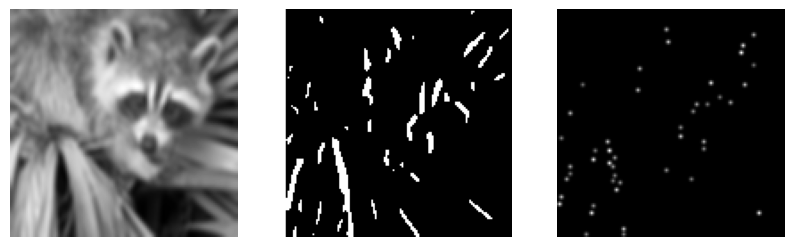

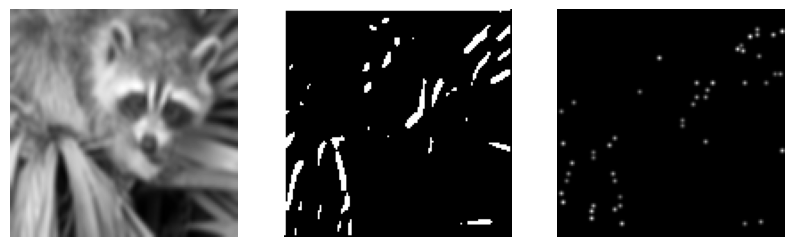

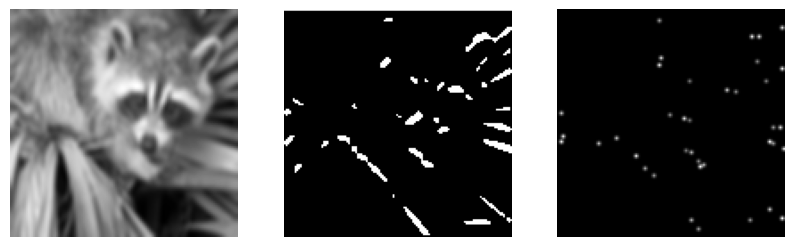

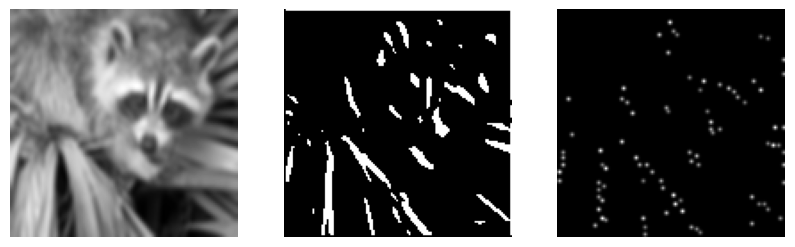

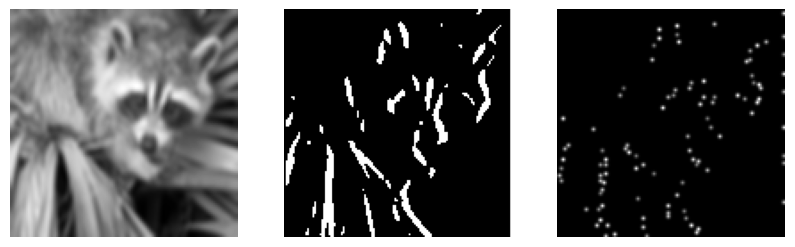

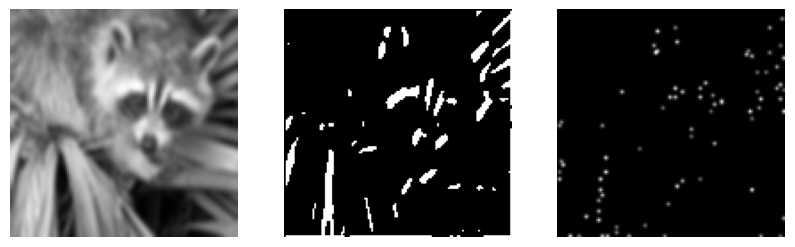

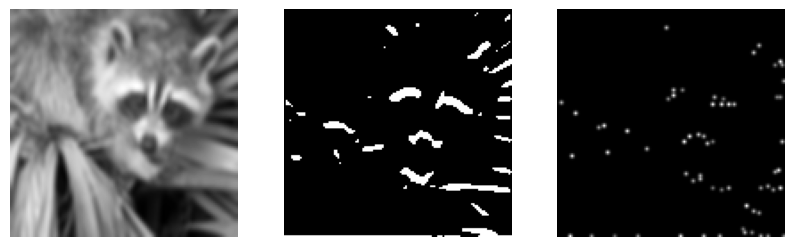

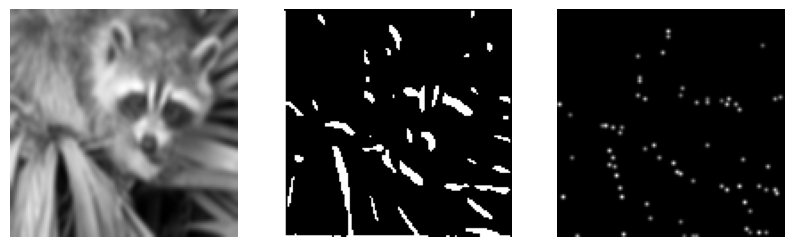

In [2]:
# Play around!
SCREEN_SIZE = (128,128)
K_SIZE      = 3 #Size of sobel kernel (e.g. 3, 5 or 7)
THRESHOLD   = 0.2 # value of initial threshold (chose between 0 and 1)
PHOSPHENE_RESOLUTION = (30,30)
DEVICE      = 'cuda:0'
STACKSIZE   = 4
BATCHSIZE   = 5

# Dummy tensor (single 128x128 image)
img   = misc.face(gray=True)
img   = cv2.GaussianBlur(img,(35,35),10)
dummy = torch.tensor(img, device=DEVICE,dtype=torch.float).view(1,1,*img.shape)/255
dummy = nn.functional.interpolate(dummy,size=SCREEN_SIZE)
dummy = dummy.repeat(BATCHSIZE,STACKSIZE,1,1)

# Edge detector model 
sobel = OrientedSobel(initial_threshold=THRESHOLD,k_size=K_SIZE,device=DEVICE,channels=STACKSIZE)

for i in range(8):
    
    # Manually adjust weighting params to visualize their effects
    w = torch.zeros(STACKSIZE, 8, 1, 1,device=DEVICE)
    w[:,i] = 1.
    sobel.weighting.weight = nn.Parameter(w)
    
    # Sobel Mask
    mask  = sobel(dummy)

    
    # Phosphene simulator
    simulator   = DifferentiablePhospheneSimulator(phosphene_resolution=PHOSPHENE_RESOLUTION,size=(SCREEN_SIZE),device=DEVICE,channels=STACKSIZE)
    phosphenes  = simulator(mask)

    # Visualization
    plot  = lambda x: plt.imshow(x[0][0].detach().cpu().numpy().squeeze(),cmap='gray') # Visualize first element from batch/stack
    plt.figure(figsize=(10,4),dpi=100)
    plt.subplot(131)
    plot(dummy)
    plt.axis('off')
    plt.subplot(132)
    plot(mask)
    plt.axis('off')
    plt.subplot(133)
    plot(phosphenes)
    plt.axis('off')
    plt.show()


Parameter containing:
tensor(0.6647, device='cuda:0', requires_grad=True)


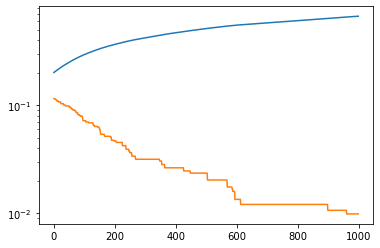

In [3]:
# Optimize as usual
thres, loss_ = [],[]
optimizer = torch.optim.Adam(model.parameters())
lossfun = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
for i in range(1000):
    model.zero_grad()
    mask = model(dummy)
    phosphenes = simulator(mask)
    loss = lossfun(phosphenes,torch.zeros_like(dummy))
    loss.backward()
    optimizer.step()
    loss_.append(loss.item())
    thres.append(model.threshold.item())

    
plt.semilogy(thres)
plt.plot(loss_)
print(model.threshold)